# Word2Vec
- here I implement word2vec with very simple example using tensorflow
- word2vec is vector representation for words with similarity
- 출처: https://github.com/minsuk-heo/python_tutorial/blob/master/data_science/nlp/word2vec_tensorflow.ipynb

## Collect Data
we will use only 10 sentences to create word vectors

In [1]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

## Remove stop words
In order for efficiency of creating word vector, we will remove commonly used words

In [2]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results

In [3]:
corpus = remove_stop_words(corpus)

In [4]:
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)

words = set(words)

In [12]:
# 표현식
tmp = {word for text in corpus for word in text.split(' ')}

In [5]:
words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

## Data generation
we will generate label for each word using skip gram.

In [14]:
word2int = {}

for i,word in enumerate(words):
    word2int[word] = i

sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
    
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])

In [15]:
for text in corpus:
    print(text)

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


In [17]:
import pandas as pd
df = pd.DataFrame(data, columns = ['input', 'label'])
df.head(10)

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


In [18]:
df.shape

(52, 2)

In [20]:
word2int

{'young': 0,
 'prince': 1,
 'princess': 2,
 'girl': 3,
 'strong': 4,
 'boy': 5,
 'woman': 6,
 'pretty': 7,
 'wise': 8,
 'man': 9,
 'king': 10,
 'queen': 11}

## Define Tensorflow Graph

In [21]:
import tensorflow as tf
import numpy as np

ONE_HOT_DIM = len(words)

# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

In [22]:
X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# making placeholders for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2 

In [23]:
# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))  # 12, 2
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

In [24]:
# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

In [25]:
# loss function: cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

## Train

In [26]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 20000
for i in range(iteration):
    # input is X_train which is one hot encoded word
    # label is Y_train which is one hot encoded neighbor word
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 3000 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  4.174265
iteration 3000 loss is :  2.1731722
iteration 6000 loss is :  1.7691982
iteration 9000 loss is :  1.7055415
iteration 12000 loss is :  1.6854697
iteration 15000 loss is :  1.6737272
iteration 18000 loss is :  1.665456


In [27]:
# Now the hidden layer (W1 + b1) is actually the word look up table
vectors = sess.run(W1 + b1)
print(vectors)

[[ 0.53072846 -0.186816  ]
 [-1.1862538   5.124532  ]
 [-4.9895773  -3.401774  ]
 [-0.7078776  -0.6834118 ]
 [ 3.4154332   1.0104535 ]
 [-0.10714184  0.96310145]
 [-1.72862    -1.023979  ]
 [ 2.7978551  -2.0847535 ]
 [-0.24473354 -3.3181934 ]
 [-1.2237642   4.3851466 ]
 [-0.20082471  0.9396346 ]
 [-0.5883076  -0.49697825]]


## Word vector in table

In [28]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,young,0.530728,-0.186816
1,prince,-1.186254,5.124532
2,princess,-4.989577,-3.401774
3,girl,-0.707878,-0.683412
4,strong,3.415433,1.010453
5,boy,-0.107142,0.963101
6,woman,-1.728620,-1.023979
7,pretty,2.797855,-2.084754
8,wise,-0.244734,-3.318193
9,man,-1.223764,4.385147


## Word vector in 2d chart

<Figure size 864x864 with 0 Axes>

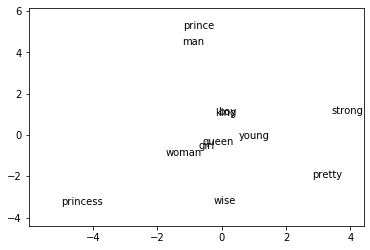

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 12))
fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
# plt.rcParams["figure.figsize"] = (10,10)

plt.show()